Everything on CPU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from utils import *

import warnings
warnings.filterwarnings("ignore")

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.__version__

'2.15.0'

In [3]:
tf.random.set_seed(2024)

In [4]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
excess_returns = pd.read_pickle('data/exc_returns.pkl')
index_returns = pd.read_pickle('data/index_returns.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

In [5]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [6]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [7]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [8]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [9]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


### Functions

In [10]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse


def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())

### SIMPLE LSTM

In [11]:
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

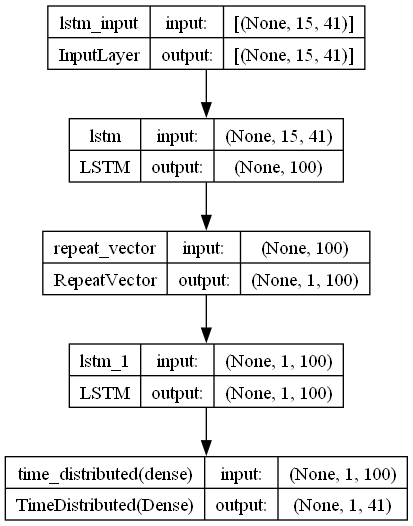

In [12]:
plot_model(model=model_enc_dec, show_shapes=True)

In [13]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50



32/32 [==============================] - 3s 8ms/step - loss: 0.1461
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0251
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 8/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 9/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 10/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 11/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 12/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 13/50
32/32 [==============================] - 0s 8m

In [14]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [15]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [16]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 5.357468
mse: 116.15093
mape: 8.46697


In [17]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [18]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [19]:
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,19.748116,632.219727,15.378692
1,ENGI FP Equity,0.658186,0.716228,4.790903
2,BAYN GY Equity,6.072619,62.363968,5.473154
3,BNP FP Equity,2.197021,7.163020,3.567451
4,PHIA NA Equity,1.681487,3.709179,5.523145
5,ISP IM Equity,0.176399,0.045789,6.351659
6,SAN FP Equity,5.150595,35.118881,6.169272
7,MC FP Equity,43.720142,2382.120361,19.102245
8,ENEL IM Equity,0.363858,0.219961,7.174294
9,CS FP Equity,2.107484,4.697862,8.647534


In [20]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

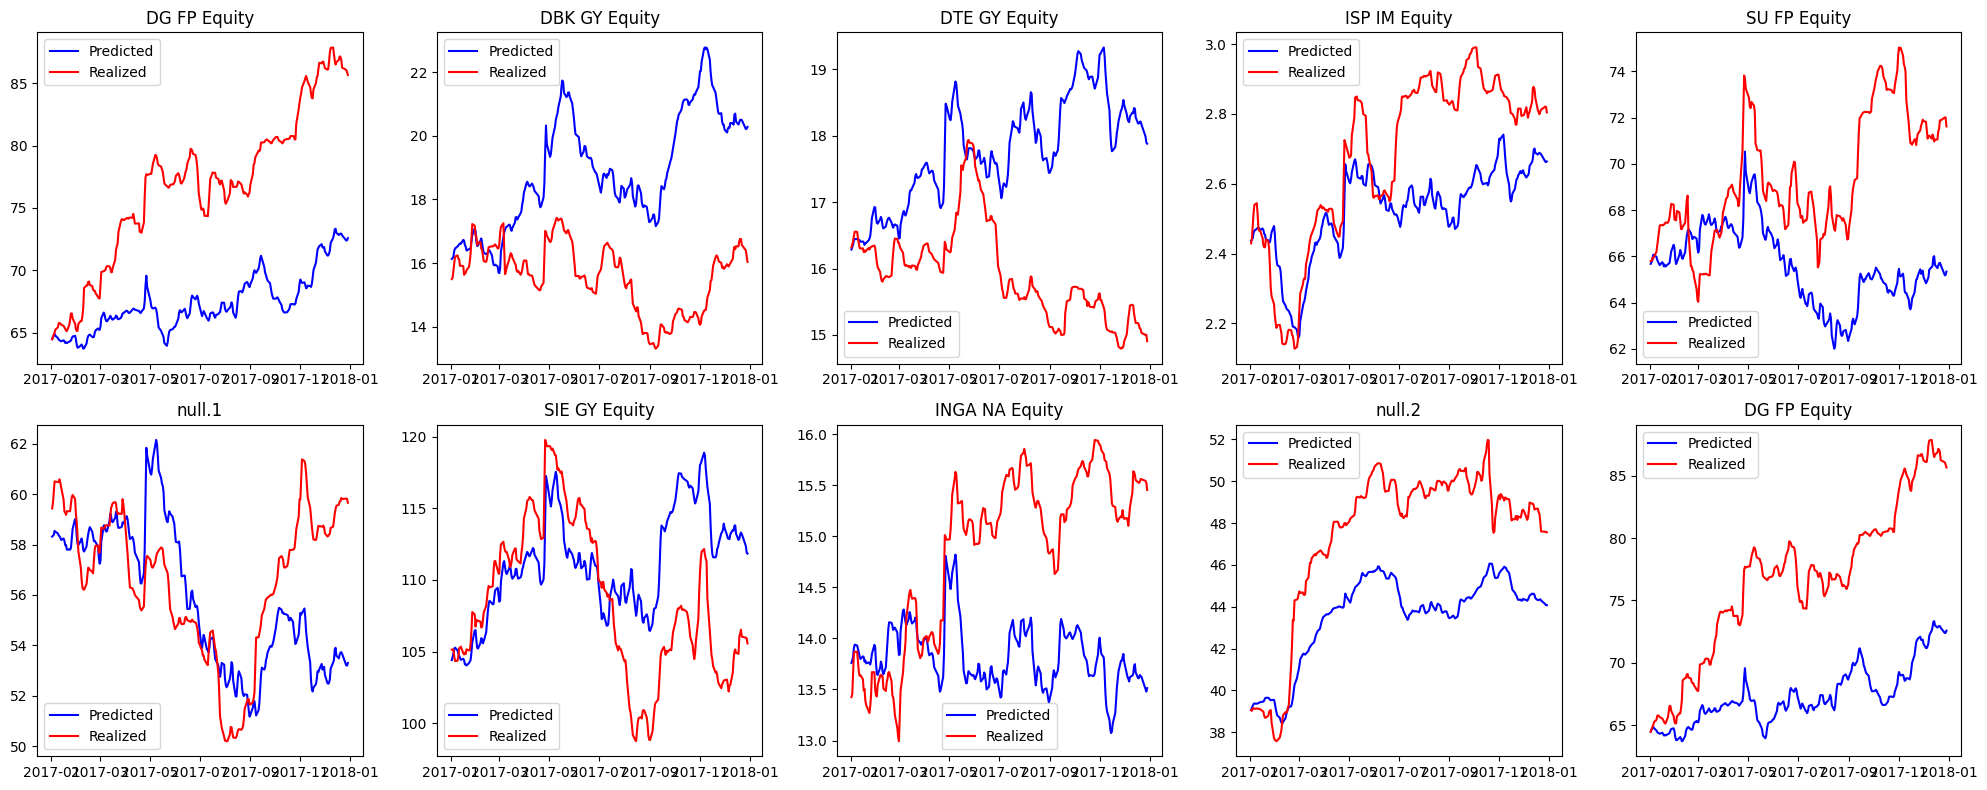

In [21]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-LSTM

In [22]:
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))
cnn_lstm.compile(loss='mse', optimizer='adam')

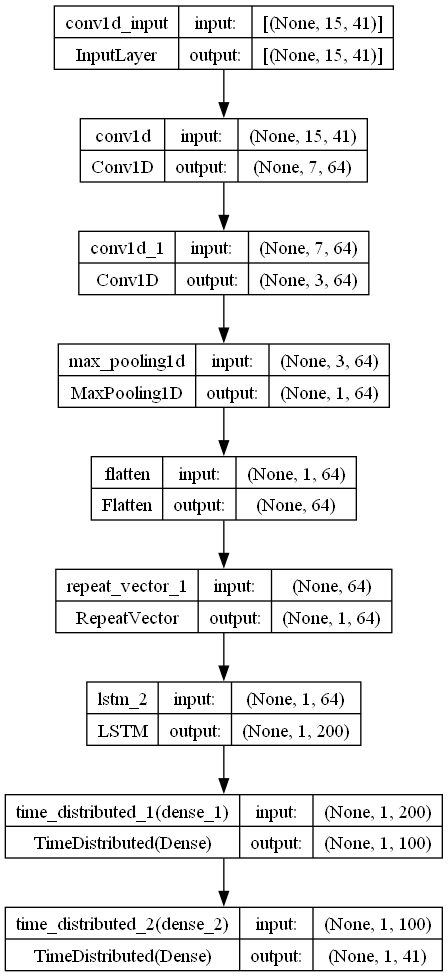

In [23]:
plot_model(model=cnn_lstm, show_shapes=True)

In [24]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 2s 5ms/step - loss: 0.1216
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0259
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0078
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 11/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 13/50
32/32 [==============================

In [25]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [26]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [27]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.398727
mse: 66.206436
mape: 7.508522


In [28]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [29]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [30]:
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,11.485501,216.057571,8.895164
1,ENGI FP Equity,1.267391,2.109915,9.169471
2,BAYN GY Equity,9.625609,115.570740,8.726073
3,BNP FP Equity,3.056180,13.350251,4.944065
4,PHIA NA Equity,1.371580,2.921034,4.586157
5,ISP IM Equity,0.219525,0.067211,8.020941
6,SAN FP Equity,5.651591,42.481613,6.776283
7,MC FP Equity,29.349951,1100.363525,12.780396
8,ENEL IM Equity,0.412075,0.255561,8.236505
9,CS FP Equity,1.934214,4.310529,7.949690


In [31]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

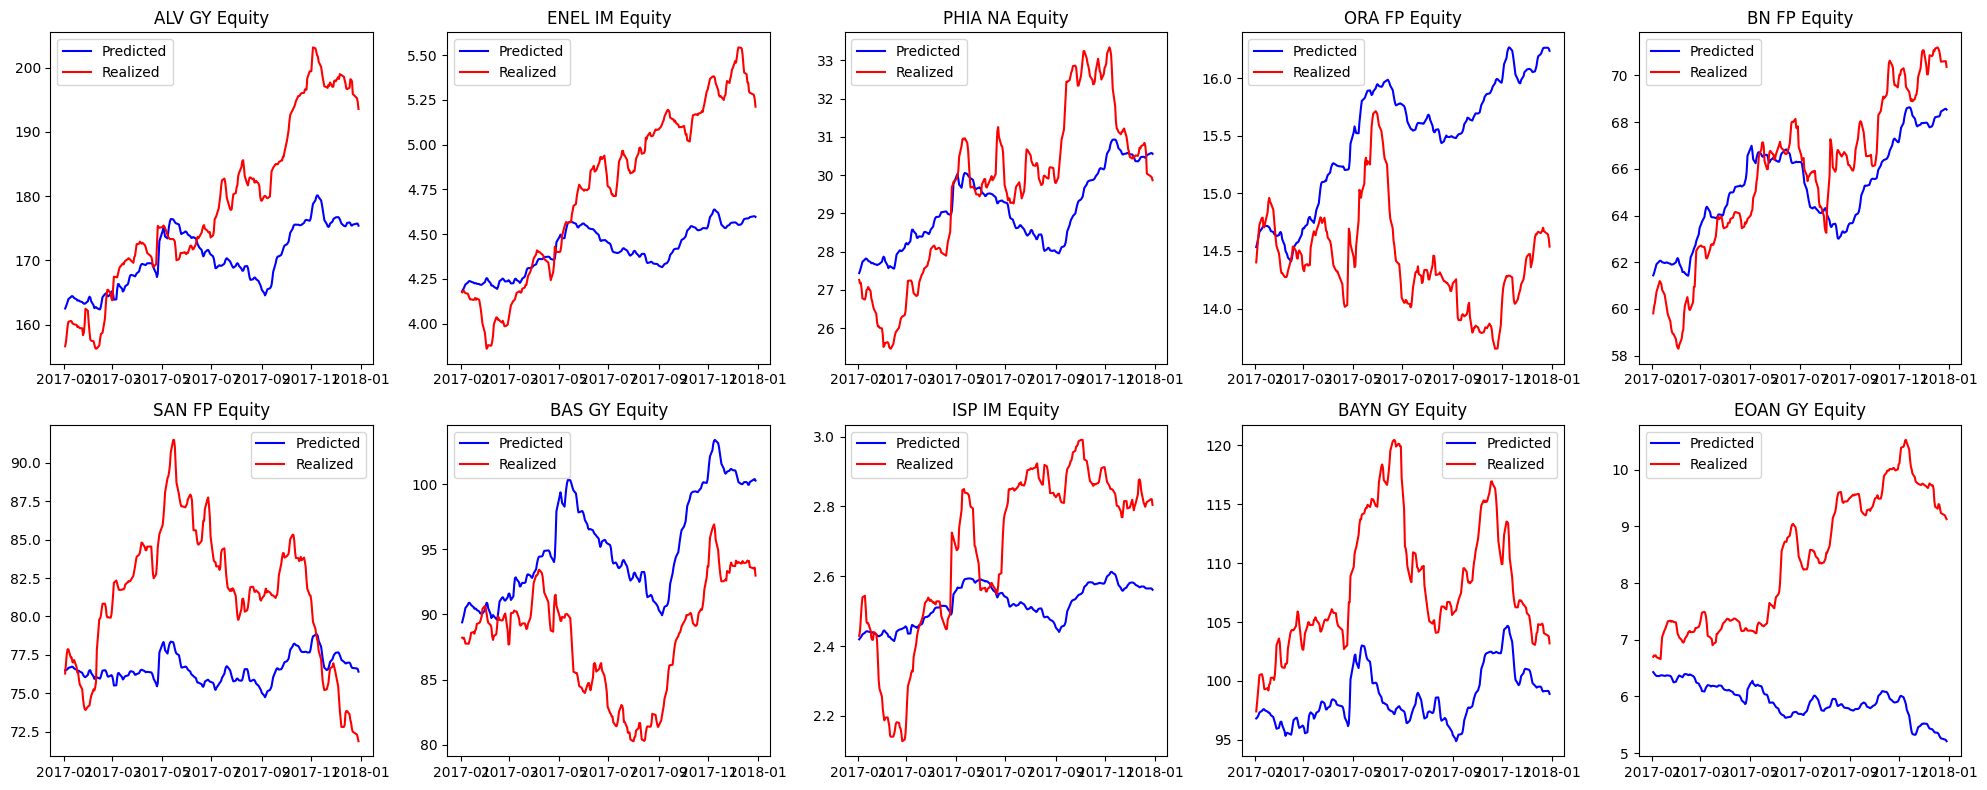

In [32]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### Multi-Head CNN-LSTM

In [33]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts :)
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=5, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

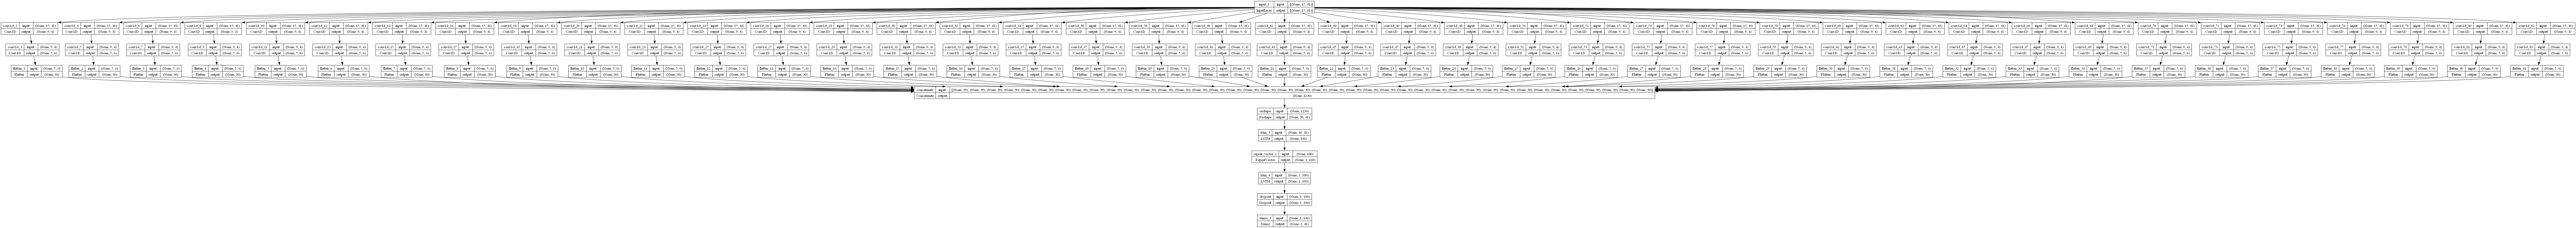

In [34]:
plot_model(model=multi_head_cnn_lstm_model, show_shapes=True)

In [35]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 17s 23ms/step - loss: 0.1979
Epoch 2/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0586
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0475
Epoch 4/50
32/32 [==============================] - 1s 24ms/step - loss: 0.0346
Epoch 5/50
32/32 [==============================] - 1s 23ms/step - loss: 0.0277
Epoch 6/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0256
Epoch 7/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0231
Epoch 8/50
32/32 [==============================] - 1s 24ms/step - loss: 0.0220
Epoch 9/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0205
Epoch 10/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0192
Epoch 11/50
32/32 [==============================] - 1s 24ms/step - loss: 0.0183
Epoch 12/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0172
Epoch 13/50
32/32 [=================

In [36]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [37]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [38]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.7080545
mse: 56.40935
mape: 8.580746


In [39]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [40]:
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,12.089314,227.060852,9.356289
1,ENGI FP Equity,2.801299,9.949557,20.099560
2,BAYN GY Equity,14.568070,243.669800,13.256788
3,BNP FP Equity,3.333651,16.695036,5.322300
4,PHIA NA Equity,0.947122,1.341785,3.191041
5,ISP IM Equity,0.296363,0.112533,10.696222
6,SAN FP Equity,6.494438,56.885876,7.768900
7,MC FP Equity,20.393845,510.194275,8.934843
8,ENEL IM Equity,0.433205,0.285049,8.594685
9,CS FP Equity,1.589912,3.054607,6.504434


In [41]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

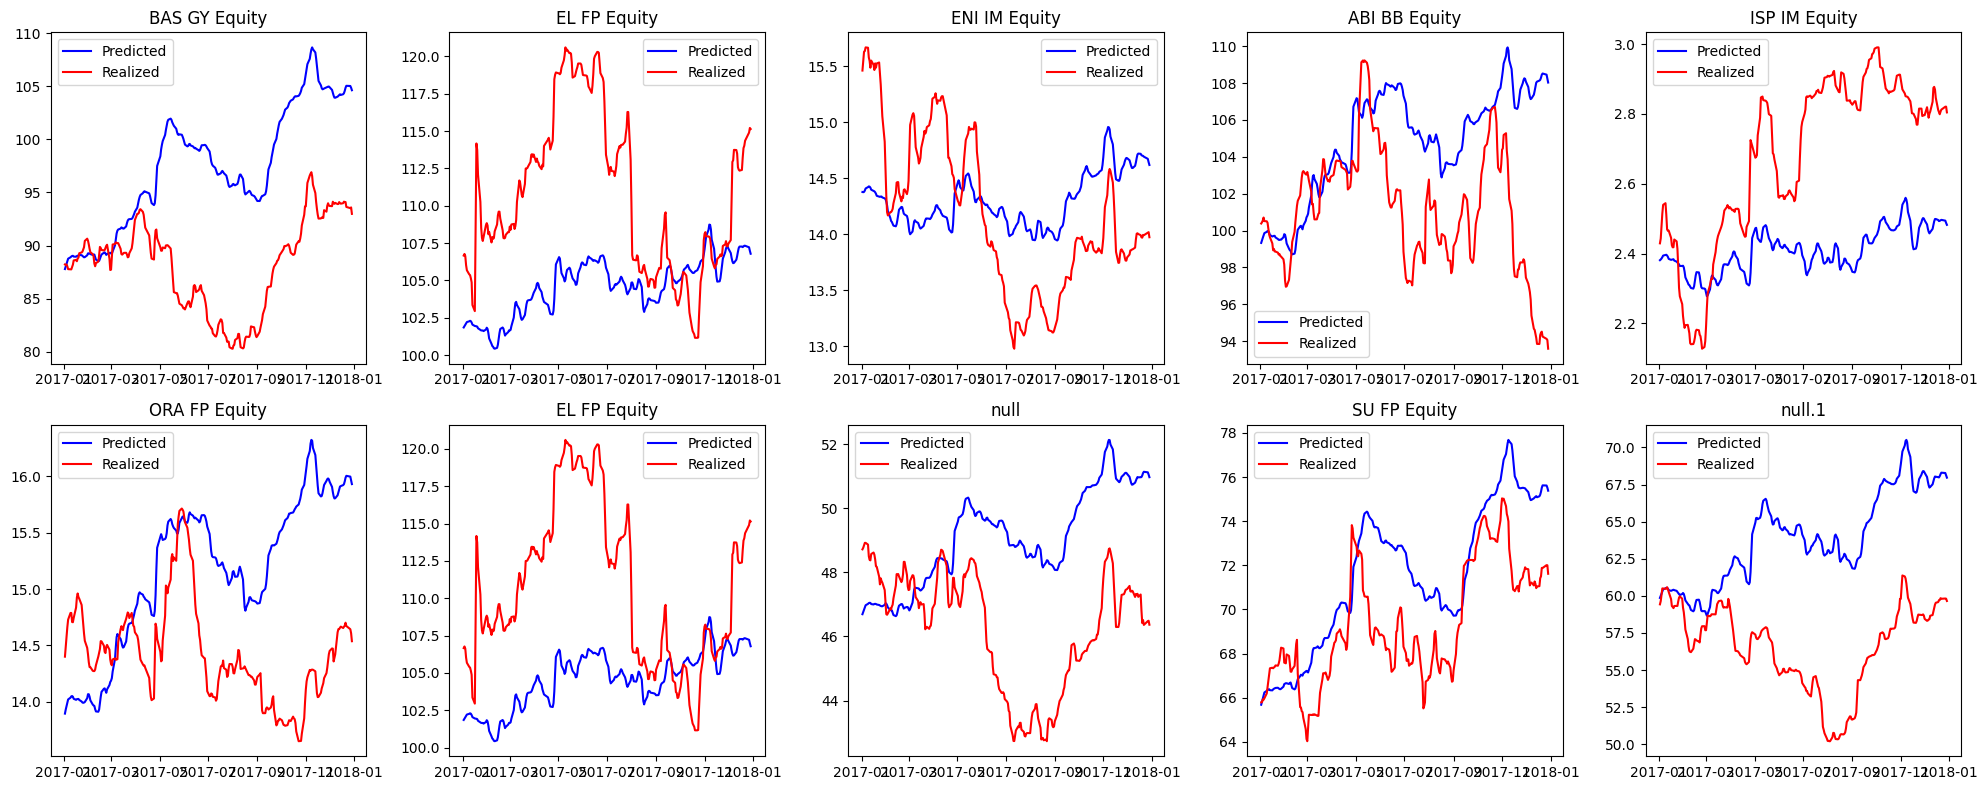

In [42]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-BiLSTM

In [43]:
# cnn_bilstm

In [44]:
plot_model(model=cnn_bilstm, show_shapes=True)

NameError: name 'cnn_bilstm' is not defined

In [ ]:
history = cnn_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
yhat = cnn_bilstm.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

In [ ]:
metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])

for stock in range(y_test_inverse.shape[1]):
    stock_name = tukey.iloc[:, stock].name
    mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
    mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

    metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)

In [ ]:
metrics_df

In [ ]:
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse_df.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse_df.iloc[:, stock].name)

plt.tight_layout()
plt.show()

----------------

### DO NOT CONSIDER CODE BELOW

In [ ]:
portfolios_LSTM = get_ranking(yhat_inverse, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, stocks_returns.loc[yhat_inverse.index[0]:])


tot_performance_LSTM['Index performance'] = (1 + index_returns.loc[yhat_inverse.index[0]:]).prod() - 1 
tot_performance_LSTM

NameError: name 'get_ranking' is not defined

In [ ]:
# TOP 5 PORTFOLIO (best one in terms of cumulative return)
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)
portfolio_series_LSTM['Top5 series'].mean(), portfolio_series_LSTM['Top5 series'].std(), portfolio_series_LSTM['Top5 series'].mean()/portfolio_series_LSTM['Top5 series'].std() * 100

(0.002940179023940558, 0.0537965213225773, 5.465370160852064)

In [ ]:
# INDEX 
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)

index_returns.loc[yhat_inverse.index[0]:].mean(), index_returns.loc[yhat_inverse.index[0]:].std(), index_returns.loc[yhat_inverse.index[0]:].mean()/index_returns.loc[yhat_inverse.index[0]:].std() * 100

(0.0003492689328041595, 0.00626025876636661, 5.5791453011593575)

In [ ]:
plot_portfolios(portfolio_series_LSTM, index_returns.loc[yhat_inverse.index[0]:])

--------------